In [1]:
include("../BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities
using DataStructures: Queue, enqueue!, dequeue!

In [2]:
# True unknown position update matrix for the moving object
Random.seed!(1)
M = [1. -0.4; 0.3 0.8]
eigen(M)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
2-element Array{Complex{Float64},1}:
 0.8999999999999999 - 0.33166247903553997im
 0.8999999999999999 + 0.33166247903553997im
vectors:
2×2 Array{Complex{Float64},2}:
 0.755929-0.0im       0.755929+0.0im
 0.188982+0.626783im  0.188982-0.626783im

In [3]:
T = 15
position = 3*ones(2,T)

for t=2:T
    position[:,t] = M*position[:,t-1]
end

In [4]:
# sensor locations
sensor1 = [5.,5.]
sensor2 = [-2.,0.]
sensor3 = [0.,15.]
;

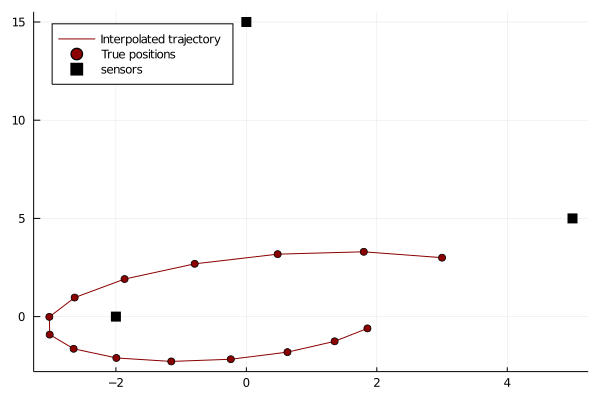

In [5]:
# Visualization of sensors and true discrete positions of the moving object
plot(position[1,:],position[2,:],color=:redsblues,legend=:topleft, label="Interpolated trajectory")
plot!(position[1,:],position[2,:], seriestype = :scatter,color=:redsblues, label="True positions")
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square, label="sensors")

In [6]:
observation = zeros(3,T)

disturbance1 = Normal(0,sqrt(1.0))
disturbance2 = Normal(0,sqrt(1.25))
disturbance3 = Normal(0,sqrt(0.9))

for t=1:T
    o1 = sqrt(sum((position[:,t]-sensor1).^2)) + rand(disturbance1)
    o2 = sqrt(sum((position[:,t]-sensor2).^2)) + rand(disturbance2)
    o3 = sqrt(sum((position[:,t]-sensor3).^2)) + rand(disturbance3)
    obs = [o1,o2,o3]
    observation[:,t] = obs
end

# Model Specification

In [7]:
# Newtonian dynamics assumption
A = [1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.]
B = [1. 0. 0. 0.; 0. 1. 0. 0.]

# Priors
p_r = MvNormal(zeros(3),[1 0.5 0.5;0.5 1 0.5; 0.5 0.5 1])
p_z_init = MvNormal(zeros(4),100*diagm(0=>ones(4)))
p_W = Wishart(4,diagm(0=>ones(4)))

# Non-conjugate loglikelihood function
function log_likelihood(y,z,r)
    x = B*z
    o1_est = sqrt(sum((x-sensor1).^2))
    o2_est = sqrt(sum((x-sensor2).^2))
    o3_est = sqrt(sum((x-sensor3).^2))
    o_est = [o1_est,o2_est,o3_est]
    R = diagm(0=>exp.(r))
    logpdf(MvNormal(o_est,R),y)
end

# Nonlinear mapping isolated
function g(z)
    x = B*z
    o1_est = sqrt(sum((x-sensor1).^2))
    o2_est = sqrt(sum((x-sensor2).^2))
    o3_est = sqrt(sum((x-sensor3).^2))
    o_est = [o1_est,o2_est,o3_est]
end

g (generic function with 1 method)

# Inference

In [8]:
# Mean parameterization of Wishart distribution. Useful for moment matching methods like EP
struct WishartMeanParameterization
    μ
    function WishartMeanParameterization(μ::Vector)
        new(μ)
    end
end

# Expectations
logdetmean(p::WishartMeanParameterization) = p.μ[end]
meanW(p::WishartMeanParameterization) = Matrix(Hermitian(reshape(p.μ[1:end-1],(Int(sqrt(length(p.μ)-1)),Int(sqrt(length(p.μ)-1))))))

meanW (generic function with 1 method)

In [9]:
# VMP message on mvnormal node towards mean for given observation and Wishart mean parameterization for precision
function mvnormalWMP(x::Vector, μ::Nothing, τ::WishartMeanParameterization)
    MvNormal(x,inv(meanW(τ)))
end

mvnormalWMP (generic function with 1 method)

In [10]:
function transform2S(q_r, n_samples)
    _, T_func, _, _, _ = exp_family(Wishart(3,diagm(0=>ones(3))));
    S_s = zeros(10)
    for n=1:n_samples
        r_s = rand(q_r)
        St = T_func(diagm(0=>1 ./ exp.(r_s)))
        S_s .+= St
    end
    S_s = S_s/n_samples
    q_S = WishartMeanParameterization(S_s)
end

transform2S (generic function with 1 method)

In [11]:
# initialize recognition factors for r, S and W so that q_z can be updated
q_r = p_r
q_W = p_W
# p(S|r) = δ(S-exp(r))
n_samples = 1000
q_S = transform2S(q_r, n_samples)
;

In [12]:
# message collision that realizes importance sampling to match moments
function collideGF(m1::MvNormal, m2::Function, n_samples)
    d = length(mean(m1))
    _, T_func, _, _, _ = exp_family(m1)
    un_weights = zeros(n_samples)
    samples = Array{Array{Float64,1}}(undef, n_samples)
    for n=1:n_samples
        sample = rand(m1)
        samples[n] = sample
        un_weights[n] = m2(sample)
    end
    weights = un_weights./sum(un_weights)
    means = sum(weights.*T_func.(samples))
    μ = means[1:d]
    V = Matrix(Hermitian(reshape(means[d+1:end],(d,d)) - μ*μ'))
    MvNormal(μ,V)
end

collideGF (generic function with 1 method)

In [13]:
# approximate message towards z
function approx_message_z(z::Vector,obs::Vector,q_S::WishartMeanParameterization)
    m_x = mvnormalWMP(obs,nothing,q_S)
    pdf(m_x,g(z))
end

approx_message_z (generic function with 1 method)

In [14]:
# approximate message towards r
function approx_message_r(r::Vector,observations::Matrix,q_x::Array{MvNormal},T::Int)
    m_s = mvnormal(observations[:,1],q_x[1],nothing)
    for t=2:T
        m_s = collide(m_s, mvnormal(observations[:,t],q_x[t],nothing))
    end
    f(r) = diagm(0 => 1 ./ exp.(r))
    pdf(m_s, f(r))
end

approx_message_r (generic function with 1 method)

In [15]:
function filter(qW, qS, T)
    W = mean(qW)
    forward_estimates = Array{MvNormal}(undef, T)
    obs = observation[:,1]
    m_z(z) = approx_message_z(z,obs,qS)  
    forward_estimates[1] = collideGF(p_z_init,m_z,n_samples)
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(4),Matrix(Hermitian(inv(W))))
        obs = observation[:,t]
        m_z(z) = approx_message_z(z,obs,qS)
        forward_estimates[t] = collideGF(predict,m_z,n_samples)
    end
    return forward_estimates
end

function smooth(forward_estimates, qW, T)
    W = mean(qW)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

In [16]:
function transform2x(qz,n_samples,T)
    qx = Array{MvNormal}(undef, length(qz))
    _, T_func, _, _, _ = exp_family(MvNormal(zeros(3),diagm(0=>ones(3))))
    for t=1:T
        q = qz[t]
        samples = Array{Array{Float64,1}}(undef, n_samples)
        for n=1:n_samples
            sample = g(rand(q))
            samples[n] = T_func(sample)
        end
        means = sum(samples)/n_samples
        μ = means[1:3]
        V = Matrix(Hermitian(reshape(means[4:end],(3,3)) - μ*μ'))
        qx[t] = MvNormal(μ,V)
    end
    return qx
end

transform2x (generic function with 1 method)

In [17]:
n_its = 5
FE = zeros(n_its+1)
# Variational updates
for i=1:n_its
    # Update q(z_{1:T}) and q(x_{1:T})
    forward_estimates = filter(q_W,q_S,T)
    smooth_estimates, joint_dists = smooth(forward_estimates, q_W, T)
    q_x = transform2x(smooth_estimates,n_samples,T)
    
    # Calculate Free Energy before q_W and q_r updates. FE_0
    if i==1
        F = -entropy(q_W) -entropy(q_r) - entropy(smooth_estimates[1])
        F += cross_entropy(q_W,p_W) + cross_entropy(q_r,p_r) + cross_entropy(smooth_estimates[1], p_z_init)
        for t=1:T-1
            F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
            F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,q_W)
            Av_t = 0
            for s=1:100
                Av_t -= log_likelihood(observation[:,t],rand(smooth_estimates[t]),rand(q_r))
            end
            F += Av_t/100
        end
        Av_T = 0
        for s=1:100
            Av_T -= log_likelihood(observation[:,T],rand(smooth_estimates[T]),rand(q_r))
        end
        F += Av_T/100
        FE[1] = F
    end
    
    # Update qW
    q_W = p_W
    for t=1:T-1
        message = transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,nothing)
        q_W = collide(q_W,message,canonical=true)
    end
    q_W = exp_family(q_W)
    
    # Update q_r and q_S
    m_r(r) = approx_message_r(r,observation,q_x,T)
    q_r = collideGF(p_r,m_r,n_samples)
    q_S = transform2S(q_r, n_samples)
    
    # Calculate Free Energy
    F = -entropy(q_W) -entropy(q_r) - entropy(smooth_estimates[1])
    F += cross_entropy(q_W,p_W) + cross_entropy(q_r,p_r) + cross_entropy(smooth_estimates[1], p_z_init)
    for t=1:T-1
        F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
        F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,q_W)
        Av_t = 0
        for s=1:100
            Av_t -= log_likelihood(observation[:,t],rand(smooth_estimates[t]),rand(q_r))
        end
        F += Av_t/100
    end
    Av_T = 0
    for s=1:100
        Av_T -= log_likelihood(observation[:,T],rand(smooth_estimates[T]),rand(q_r))
    end
    F += Av_T/100
    FE[i+1] = F
end

In [18]:
inv(mean(q_W))

4×4 Array{Float64,2}:
  0.232836     0.0228337   0.0106236  -0.00703995
  0.0228337    0.268112   -0.0106853  -0.0108318
  0.0106236   -0.0106853   0.247371    0.023218
 -0.00703995  -0.0108318   0.023218    0.200728

In [19]:
q_r

FullNormal(
dim: 3
μ: [-0.353953107729401, 0.15176263958724442, -0.3054525640315881]
Σ: [0.12579678333569497 0.013591212185059223 0.012110435885109877; 0.013591212185059223 0.10129781180192986 0.009394624417003894; 0.012110435885109877 0.009394624417003894 0.12417649839974729]
)


In [20]:
forward_estimates = filter(q_W,q_S,T)
smooth_estimates, joint_dists = smooth(forward_estimates, q_W, T)
;

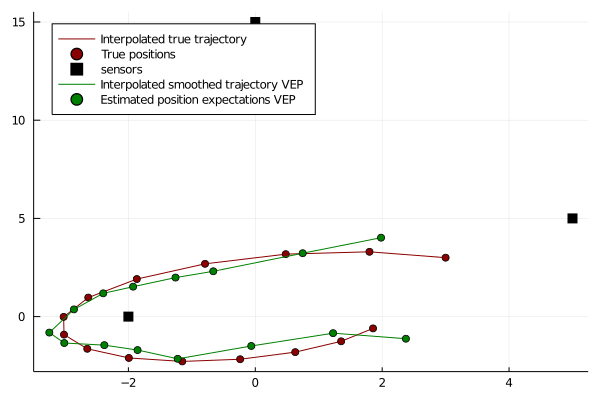

In [21]:
smooth_plot = zeros(2,T)
for t=1:T
    smooth_plot[:,t] = mean(smooth_estimates[t])[1:2]
end
plot(position[1,:],position[2,:],color=:redsblues,legend=:topright, label="Interpolated true trajectory")
plot!(position[1,:],position[2,:], seriestype = :scatter,color=:redsblues, label="True positions")
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square, label="sensors")
plot!(smooth_plot[1,:],smooth_plot[2,:],color=:green,legend=:topleft, label="Interpolated smoothed trajectory VEP")
plot!(smooth_plot[1,:],smooth_plot[2,:], seriestype = :scatter,color=:green, label="Estimated position expectations VEP")

In [22]:
FE

6-element Array{Float64,1}:
 132.6698333643416
  99.64777310764839
  97.1133282579579
  96.65553796821153
  97.33107816254129
  97.61034681764227

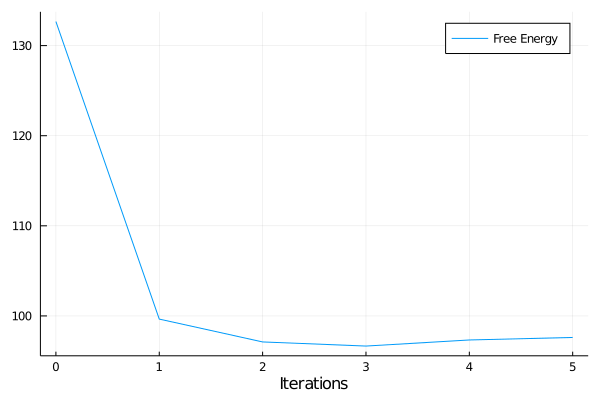

In [24]:
plot(collect(0:1:n_its),FE, label="Free Energy")
xlabel!("Iterations")